# Exploring Security Practices in Infrastructure as Code: An Empirical Study of AWS Terraform Configurations

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.dpi'] = 300

In [22]:
RESULTS_FILE = "./csv/results-tfsec.csv"
POLICIES_FILE = "./csv/policies-tfsec.csv"
DATASET = "./csv/dataset-tfsec.csv"
METRICS_FILE = "./csv/dataset_repo_metadata.csv"

Retrieve the list of the 121 selected policies and their mapped categories.
We also print the policies list to use in the checkov_looper.py Python script.

In [23]:
categories = {}
policies = {}
p_names = {}
with open(POLICIES_FILE, 'r') as f:
    f.readline()
    policies_rows = f.readlines()
    for row in policies_rows:
        s_row = row.split(',')
        if s_row[5] == "TRUE":
            policy_id = s_row[0]
            policy_name = s_row[3]
            policy_description = s_row[4]
            policy_category = s_row[6].strip('\n')
            if policy_category == "":
                policy_category = "Uncategorized"

            policies[policy_id] = policy_description
            categories[policy_id] = policy_category
            p_names[policy_id] = policy_name

In [24]:
print("CHECK_LIST = " + ",".join(policies))

CHECK_LIST = AVD-AWS-0137,AVD-AWS-0138,AVD-AWS-0139,AVD-AWS-0123,AVD-AWS-0057,AVD-AWS-0141,AVD-AWS-0065,AVD-AWS-0075,AVD-AWS-0076,AVD-AWS-0128,AVD-AWS-0026,AVD-AWS-0027,AVD-AWS-0084,AVD-AWS-0127,AVD-AWS-0131,AVD-AWS-0008,AVD-AWS-0028,AVD-AWS-0130,AVD-AWS-0102,AVD-AWS-0104,AVD-AWS-0105,AVD-AWS-0107,AVD-AWS-0009,AVD-AWS-0164,AVD-AWS-0129,AVD-AWS-0029,AVD-AWS-0122,AVD-AWS-0133,AVD-AWS-0078,AVD-AWS-0079,AVD-AWS-0080,AVD-AWS-0082,AVD-AWS-0037,AVD-AWS-0038,AVD-AWS-0039,AVD-AWS-0040,AVD-AWS-0041,AVD-AWS-0018,AVD-AWS-0048,AVD-AWS-0042,AVD-AWS-0043,AVD-AWS-0046,AVD-AWS-0126,AVD-AWS-0096,AVD-AWS-0097,AVD-AWS-0135,AVD-AWS-0134,AVD-AWS-0098,AVD-AWS-0109,AVD-AWS-0053,AVD-AWS-0052,AVD-AWS-0054,AVD-AWS-0047,AVD-AWS-0023,AVD-AWS-0025,AVD-AWS-0007,AVD-AWS-0017,AVD-AWS-0066,AVD-AWS-0067,AVD-AWS-0045,AVD-AWS-0051,AVD-AWS-0034,AVD-AWS-0035,AVD-AWS-0036,AVD-AWS-0064,AVD-AWS-0095,AVD-AWS-0136,AVD-AWS-0101,AVD-AWS-0020,AVD-AWS-0021,AVD-AWS-0022,AVD-AWS-0014,AVD-AWS-0015,AVD-AWS-0016,AVD-AWS-0162,AVD-AWS-0161

## RQ1: Category Mapping Distribution

In [25]:
categories_count = {}
for policy in policies:
    categories_count[categories.get(policy, "Uncategorized")] = categories_count.get(categories.get(policy, "Uncategorized"), 0) + 1

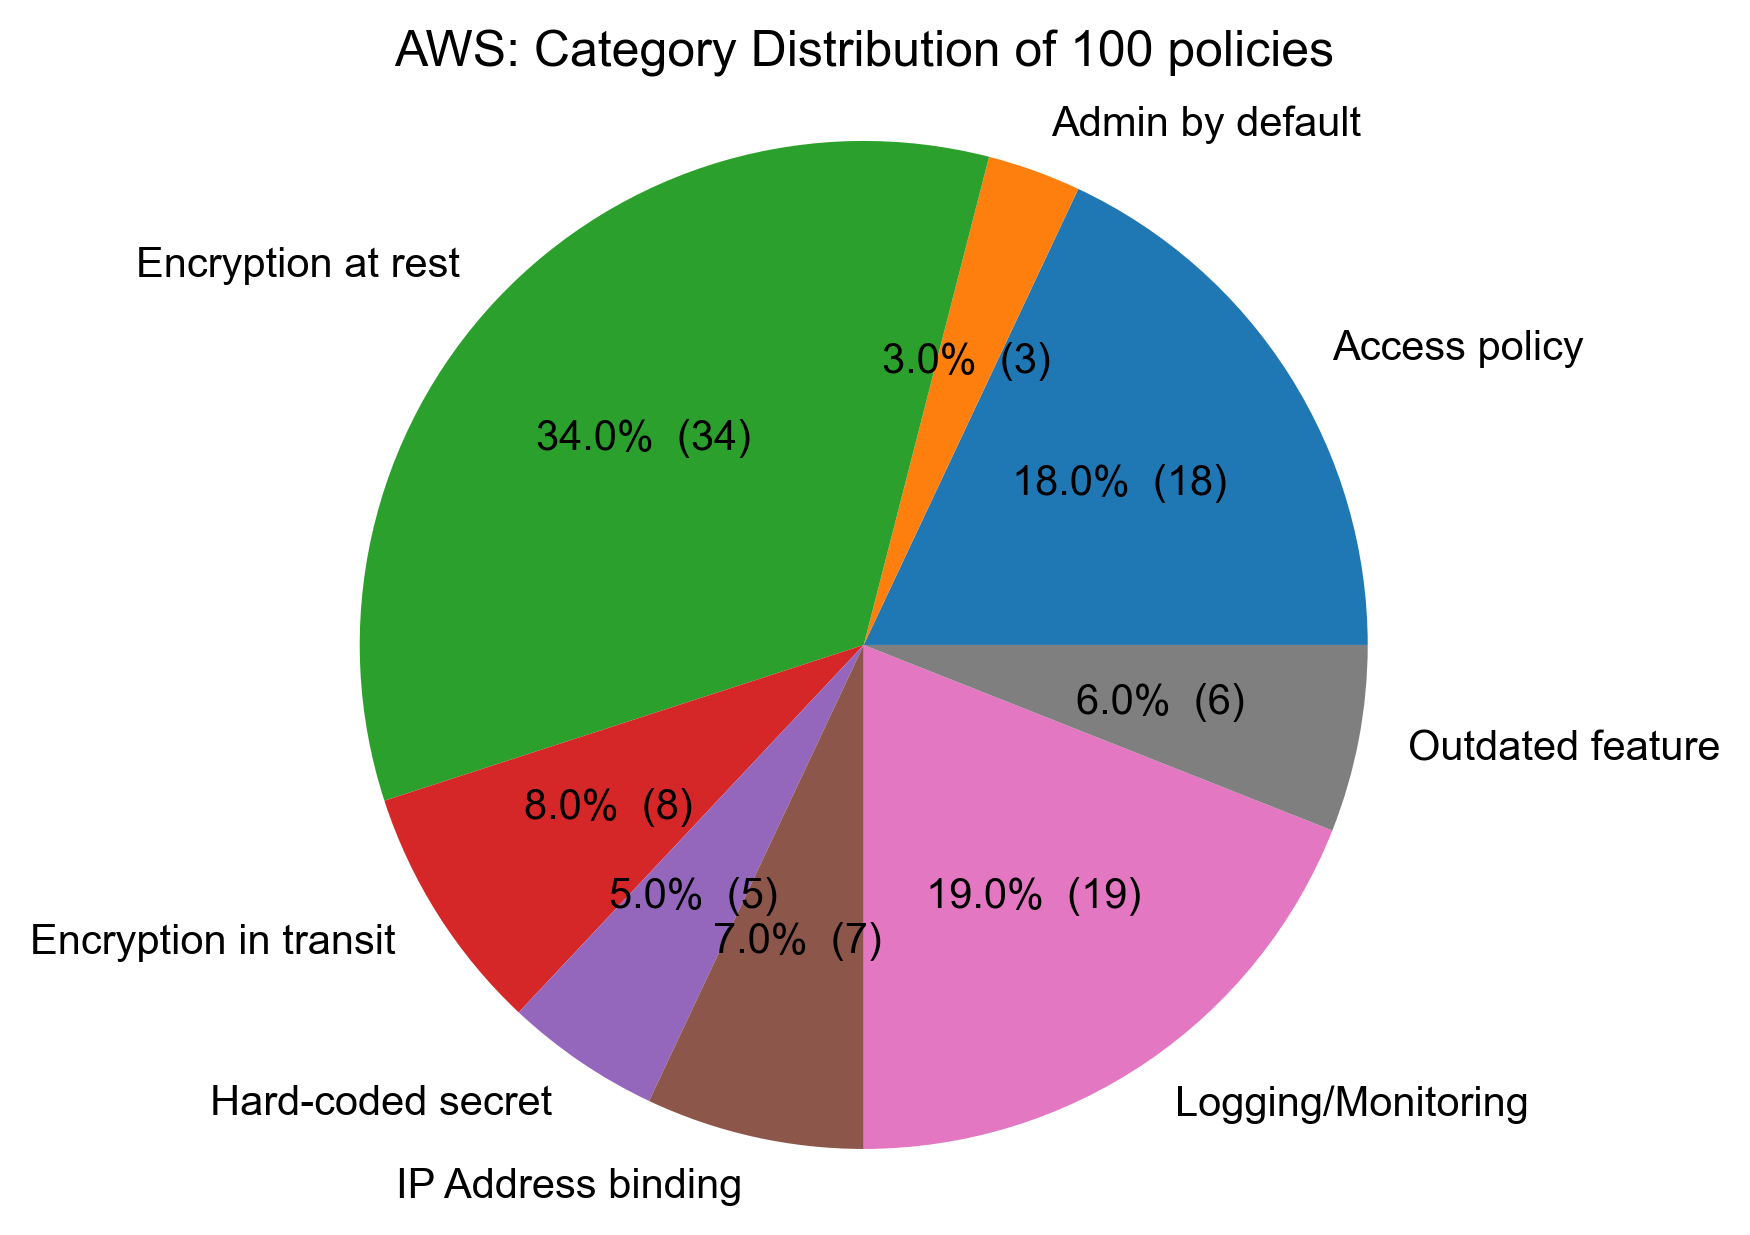

In [26]:
labels2 = sorted([*categories_count.keys()])
sizes2 = [categories_count[k] for k in labels2]
fig2, ax2 = plt.subplots()
ax2.pie(sizes2, labels=labels2, autopct=lambda p : '{:.1f}%  ({:,.0f})'.format(p,p * sum(sizes2)/100))
ax2.axis('equal')
ax2.set(title="AWS: Category Distribution of {} policies".format(len(policies)))
plt.show()

## Results analysis

Load the repository list of our dataset and the checkov results

In [27]:
with open(DATASET, 'r') as f:
    tmp_repo_names = f.readlines()
repo_names = [k.strip("\n") for k in tmp_repo_names]

## Dataset metrics

In [28]:
stars = []
forks = []
contrib = []
with open(METRICS_FILE, 'r') as f:
    #f.readline()
    rows = f.readlines()
    for item in rows:
        column = item.split(',')
        if column[0] in repo_names:
            stars.append(int(column[1]))
            forks.append(int(column[2]))
            contrib.append(int(column[3].strip("\n")))

In [29]:
print("Average stars: {}".format(np.average(stars)))
print("Median stars: {}".format(np.median(stars)))
print("Average forks: {}".format(np.average(forks)))
print("Median forks: {}".format(np.median(forks)))
print("Average conrtib: {}".format(np.average(contrib)))
print("Median contrib: {}".format(np.median(contrib)))

Average stars: 174.76309226932668
Median stars: 7.0
Average forks: 43.25935162094763
Median forks: 4.0
Average conrtib: 7.598503740648379
Median contrib: 3.0


In [30]:
with open(RESULTS_FILE, 'r') as f:
    f.readline()
    repo_results = f.readlines()

## Results aggregation
Aggregate the results per category. Ensures all policies in the results are categorized (have been selected and mapped to a category).

In [31]:
passed_count_dict = {}
failed_count_dict = {}
categories_passed_counts = {}
categories_failed_counts = {}
uncategorized_policies = {}
repo_results_list = []
for row in repo_results:
    columns = row.split(',')
    repo_name = columns[0]
    if repo_name in repo_names:
        passed_policies = columns[3].split(';')
        failed_policies = columns[4].split(';')
        repo_results_list.append([len(passed_policies), len(failed_policies)])

        for policy in passed_policies:
            if len(policy) > 0:
                if categories.get(policy, "Uncategorized") == "Uncategorized":
                    uncategorized_policies[policy] = True
                    continue
                categories_passed_counts[categories.get(policy, "Uncategorized")] = categories_passed_counts.get(categories.get(policy, "Uncategorized"), 0) + 1
                passed_count_dict[policy] = passed_count_dict.get(policy, 0) + 1
                
        for policy in failed_policies:
            if len(policy) > 0:
                if categories.get(policy, "Uncategorized") == "Uncategorized":
                    uncategorized_policies[policy] = True
                    continue
                categories_failed_counts[categories.get(policy, "Uncategorized")] = categories_failed_counts.get(categories.get(policy, "Uncategorized"), 0) + 1
                failed_count_dict[policy] = failed_count_dict.get(policy, 0) + 1
                

total_count = {}
for policy in passed_count_dict:
    total_count[policy] = total_count.get(policy, 0) + passed_count_dict[policy]
for policy in failed_count_dict:
    total_count[policy] = total_count.get(policy, 0) + failed_count_dict[policy]
                    
print("Uncategorized policies: {}".format([*uncategorized_policies.keys()]))
print("Total number of passed policies: {}".format(sum(passed_count_dict.values())))
print("Total number of failed policies: {}".format(sum(failed_count_dict.values())))
print("Median number of checks per policy: {}".format(np.median([*total_count.values()])))
print("Average number of checks per policy: {}".format(np.average([*total_count.values()])))
print("STD of checks per policy: {}".format(np.std([*total_count.values()])))
print("Skewness of checks per policy: {}".format(sp.skew([*total_count.values()])))
print("Skewness of checks per policy: {}".format((np.average([*total_count.values()])-np.median([*total_count.values()]))/np.std([*total_count.values()])))

Uncategorized policies: ['AVD-GCP-0060', 'AVD-GCP-0052', 'AVD-GCP-0064', 'AVD-GCP-0054', 'AVD-GCP-0055', 'AVD-GCP-0062', 'AVD-GCP-0050', 'AVD-GCP-0063', 'AVD-GCP-0058', 'AVD-GCP-0049', 'AVD-GCP-0061', 'AVD-GCP-0056', 'AVD-GCP-0059', 'AVD-GCP-0047', 'AVD-GCP-0048', 'AVD-GCP-0057', 'AVD-GCP-0051', 'AVD-AWS-0099', 'AVD-AWS-0124', 'AVD-AWS-0143', 'AVD-AWS-0180', 'AVD-AWS-0090', 'AVD-AZU-0043', 'AVD-AZU-0040', 'AVD-AZU-0008', 'AVD-GCP-0037', 'AVD-GCP-0044', 'AVD-GCP-0043', 'AVD-GCP-0036', 'AVD-GCP-0032', 'AVD-GCP-0012', 'AVD-GCP-0006', 'AVD-GCP-0011', 'AVD-GCP-0003', 'AVD-GCP-0026', 'AVD-AWS-0178', 'AVD-AWS-0030', 'AVD-AWS-0031', 'AVD-AWS-0177', 'AVD-AWS-0176', 'AVD-AWS-0077', 'AVD-AZU-0041', 'AVD-AZU-0042', 'AVD-AZU-0020', 'AVD-AZU-0022', 'AVD-AZU-0026', 'AVD-AZU-0011', 'AVD-GCP-0045', 'AVD-GCP-0041', 'AVD-GCP-0029', 'AVD-GCP-0030', 'AVD-GCP-0027', 'AVD-GCP-0031', 'AVD-GCP-0033', 'AVD-GCP-0013', 'AVD-GCP-0024', 'AVD-GCP-0015', 'AVD-GCP-0017', 'AVD-AWS-0011', 'AVD-AZU-0021', 'AVD-AZU-0024',

In [32]:
nb_of_checks = []
for i in repo_results_list:
    nb_of_checks.append(i[0]+i[1])
rate_list = []
for i in repo_results_list:
    rate_list.append(100*i[0]/(i[0]+i[1]))
    
print("Median number of checks per repo: {}".format(np.median(nb_of_checks)))
print("Average number of checks per repo: {}".format(np.average(nb_of_checks)))
print("Skewness of checks per repo: {}".format((np.average(nb_of_checks)-np.median(nb_of_checks))/np.std(nb_of_checks)))
print("\n")
print("Median pass rate per repo: {}".format(np.median(rate_list)))
print("Average pass rate per repo: {}".format(np.average(rate_list)))

Median number of checks per repo: 34.0
Average number of checks per repo: 125.58227848101266
Skewness of checks per repo: 0.289039511259275


Median pass rate per repo: 49.42528735632184
Average pass rate per repo: 44.28398511793259


### Generate the Paper Full Table with the results

In [33]:
inv_cat = {}
for k, v in categories.items():
    inv_cat[v] = inv_cat.get(v, []) + [k]
tp = ""
for cat in inv_cat:
    p = inv_cat[cat]
    tp = tp + "\multirow{" + str(len(p)) + "}{*}{" + cat + "}"
    for i in p:
        if total_count.get(i,0) != 0:
            tp = tp + " & " + policies[i] + " & " + str(total_count.get(i,0)) + " & " + str(passed_count_dict.get(i,0)) + " & " + str(failed_count_dict.get(i,0)) + " & " + str(passed_count_dict.get(i,0)/total_count.get(i,0)*100)[:5] +"\\\\ \n"
        else:
            tp = tp + " & " + policies[i] + " & " + str(total_count.get(i,0)) + " & " + str(passed_count_dict.get(i,0)) + " & " + str(failed_count_dict.get(i,0)) + " & " +"\\\\ \n"
    tp = tp + "\hline \n"
tp = tp.replace("_", "\_")
print(tp)

\multirow{34}{*}{Encryption at rest} & Enable at-rest encryption for EMR clusters. & 0 & 0 & 0 & \\ 
 & Enable local-disk encryption for EMR clusters. & 0 & 0 & 0 & \\ 
 & A KMS key is not configured to auto-rotate. & 177 & 110 & 67 & 62.14\\ 
 & Neptune storage must be encrypted at rest & 1 & 0 & 1 & 0.0\\ 
 & Neptune encryption should use Customer Managed Keys & 1 & 0 & 1 & 0.0\\ 
 & EBS volumes must be encrypted & 54 & 25 & 29 & 46.29\\ 
 & EBS volume encryption should use Customer Managed Keys & 54 & 2 & 52 & 3.703\\ 
 & Redshift clusters should use at rest encryption & 4 & 0 & 4 & 0.0\\ 
 & Instance with unencrypted block device. & 313 & 27 & 286 & 8.626\\ 
 & Launch configuration with unencrypted block device. & 52 & 6 & 46 & 11.53\\ 
 & Ensure all data stored in the launch configuration EBS is securely encrypted & 51 & 51 & 0 & 100.0\\ 
 & There is no encryption specified or encryption is disabled on the RDS Cluster. & 34 & 10 & 24 & 29.41\\ 
 & RDS encryption has not been enabl

## RQ2/RQ3 : Category Pass/Fail Rate

In [34]:
policies_rate = {}
for policy in policies:
    if passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0) > 0:
        policies_rate[policy] = passed_count_dict.get(policy, 0) / (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0))

categories_rates = {}
for category in categories_passed_counts:
    categories_rates[category] = categories_passed_counts[category] / (categories_passed_counts[category] + categories_failed_counts[category])

#categories_rates = {}
#for policy in policies_rate:
 #   categories_rates[categories[policy]] = categories_rates.get(categories[policy], []) + [policies_rate[policy]]
#for category in categories_rates:
 #   categories_rates[category] = np.average(categories_rates.get(category, []))
print(categories_rates)

{'Encryption at rest': 0.2840957674219752, 'Outdated feature': 0.7095115681233933, 'IP Address binding': 0.6798584298584298, 'Hard-coded secret': 0.933806146572104, 'Logging/Monitoring': 0.20181219110378912, 'Admin by default': 0.8322567344694888, 'Access policy': 0.3694053914613698, 'Encryption in transit': 0.779559118236473}


In [36]:
import pickle
with open('./aws_categories_rates_tfsec.pkl', 'wb') as f:
    pickle.dump(categories_rates, f)

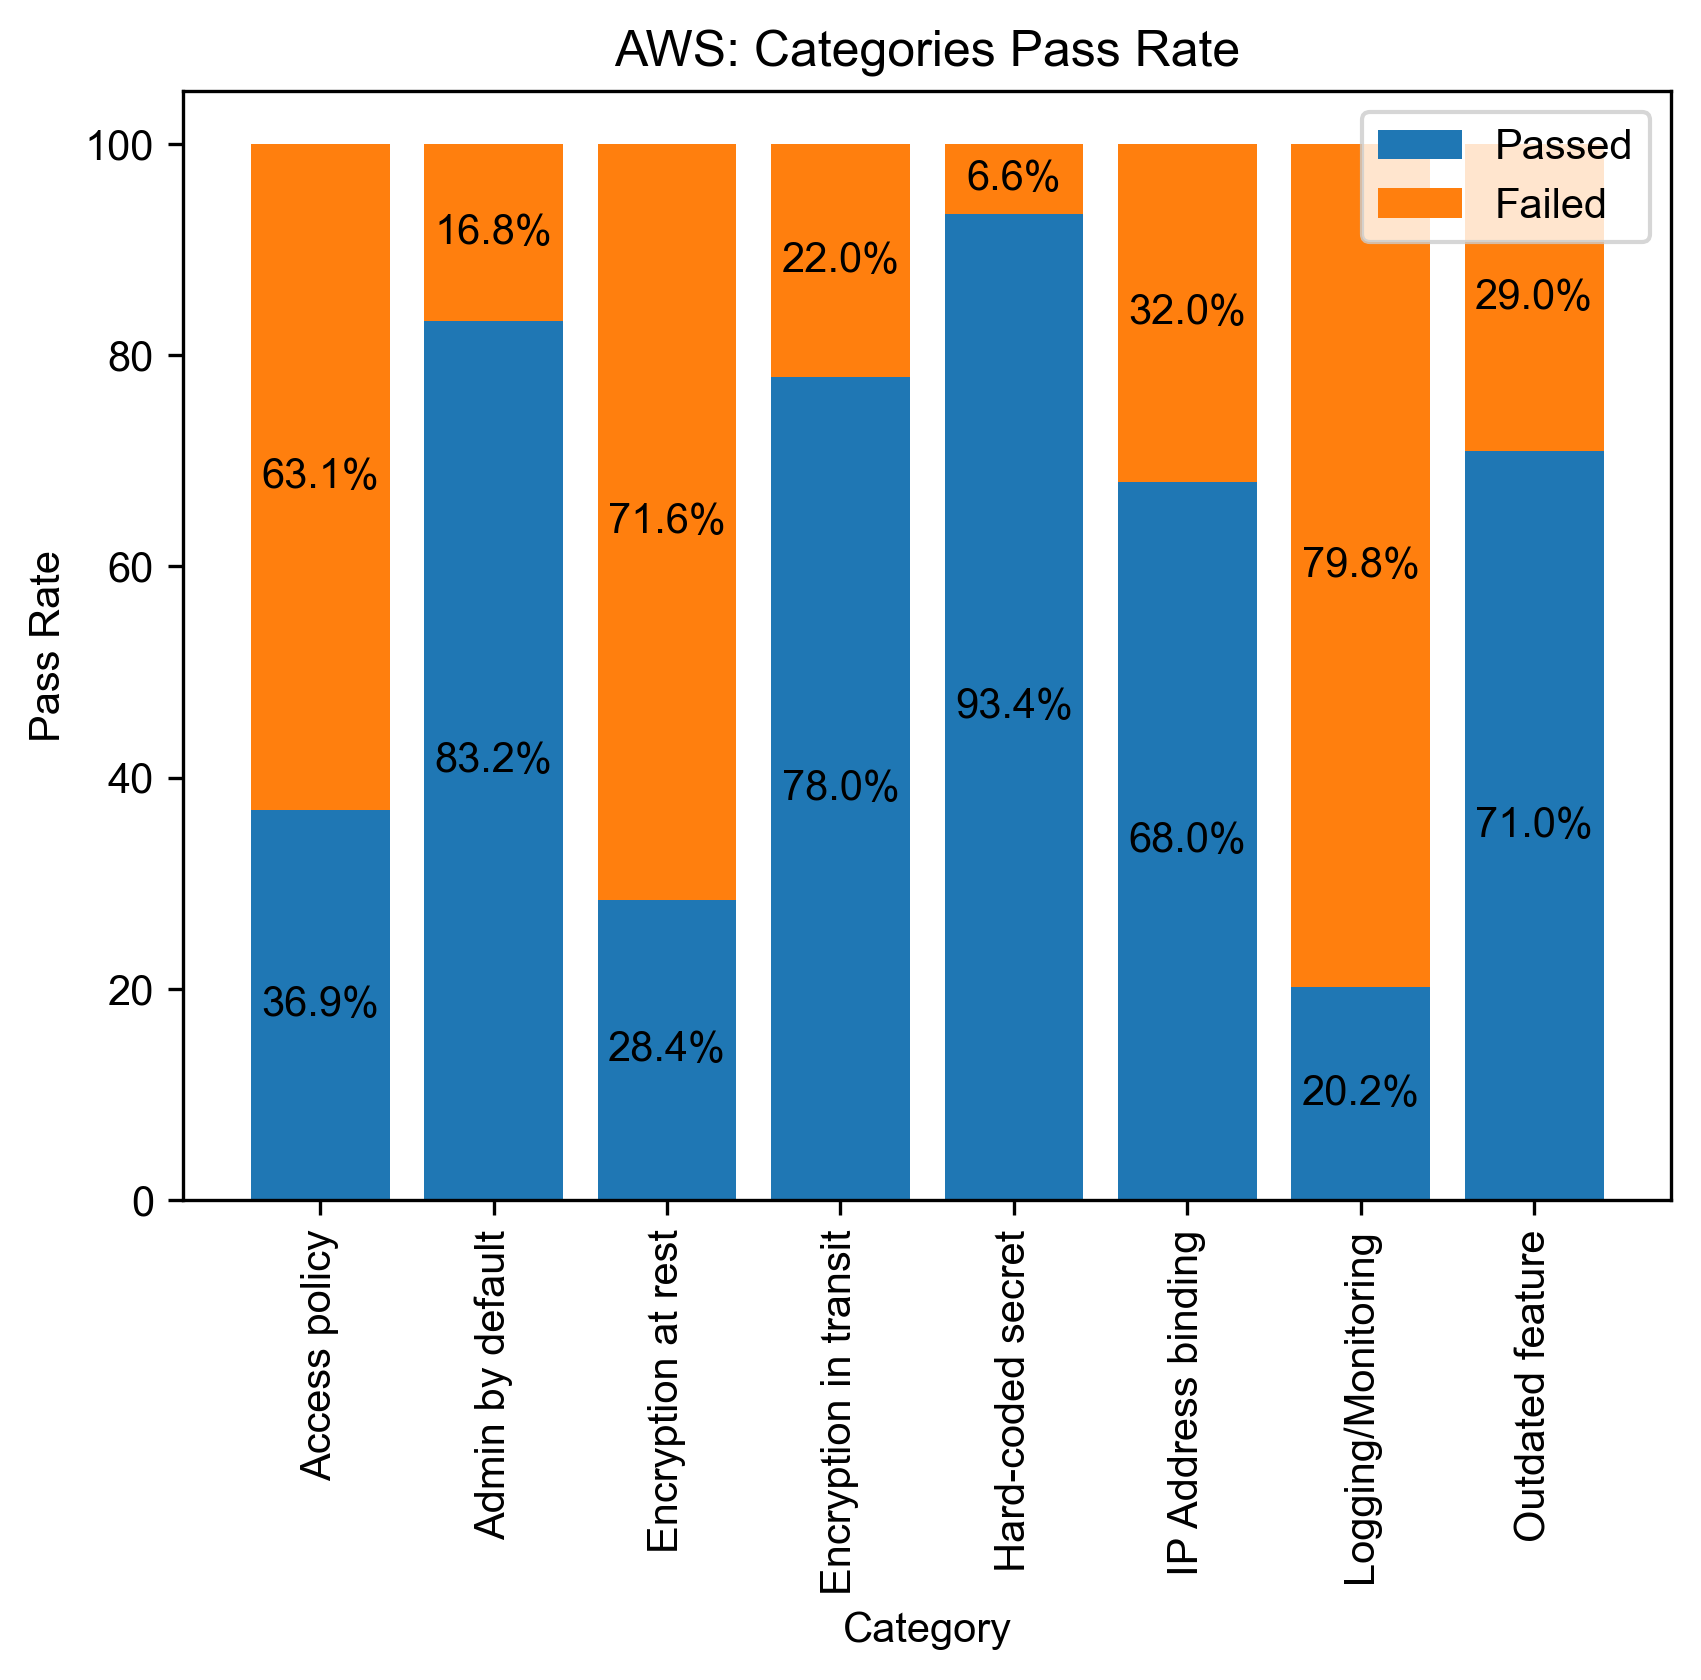

In [37]:
fig7, ax7 = plt.subplots()
x = sorted([*categories_rates.keys()])
y1 = [100*categories_rates[k] for k in x]
y2 = [100-k for k in y1]
bc1 = ax7.bar(x, y1)
bc2 = ax7.bar(x, y2, bottom=y1)
ax7.bar_label(bc1, labels=['{0:.1f}%'.format(e) for e in y1], label_type='center')
ax7.bar_label(bc2, labels=['{0:.1f}%'.format(e) for e in y2], label_type='center')
ax7.set(xlabel="Category", ylabel="Pass Rate", title="AWS: Categories Pass Rate")
ax7.legend(["Passed", "Failed"])
plt.xticks(rotation=90)
plt.show()

## RQ2/RQ3 : Best and Worst Pass/Fail Policies

In [38]:
policies_rate = {}
for policy in policies:
    if passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0) > 50:
        policies_rate[policy] = passed_count_dict.get(policy, 0) / (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0))

print("Averate Pass/Fail Rate: {}".format(np.average([*policies_rate.values()])))
        
sorted_policies_rates = sorted(policies_rate, key=policies_rate.get, reverse=True)
print("Best 5 Pass / Fail Rate Policies")
for policy in sorted_policies_rates[:6]:
    print("{} - {} - {}".format(policy, (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)), policies_rate[policy]))
print("Worst 5 Pass / Fail Rate Policies")
for policy in reversed(sorted_policies_rates[-7:]):
    print("{} - {} - {}".format(policy, (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)), policies_rate[policy]))

Averate Pass/Fail Rate: 0.4187176645062654
Best 5 Pass / Fail Rate Policies
AVD-AWS-0129 - 80 - 1.0
AVD-AWS-0029 - 311 - 1.0
AVD-AWS-0122 - 51 - 1.0
AVD-AWS-0136 - 149 - 0.9664429530201343
AVD-AWS-0047 - 1326 - 0.9638009049773756
AVD-AWS-0135 - 197 - 0.949238578680203
Worst 5 Pass / Fail Rate Policies
AVD-AWS-0004 - 617 - 0.008103727714748784
AVD-AWS-0033 - 151 - 0.026490066225165563
AVD-AWS-0027 - 54 - 0.037037037037037035
AVD-AWS-0132 - 905 - 0.07292817679558011
AVD-AWS-0025 - 135 - 0.08148148148148149
AVD-AWS-0131 - 313 - 0.08626198083067092
AVD-AWS-0028 - 310 - 0.1032258064516129


Print Average number of test per category

In [39]:
policies_nb_runs = {}
for policy in policies:
    policies_nb_runs[policy] = passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)
mean_category_runs = {}
for policy in policies_nb_runs:
    mean_category_runs[categories.get(policy, "Uncategorized")] = mean_category_runs.get(categories.get(policy, "Uncategorized"), []) + [policies_nb_runs[policy]]

for category in mean_category_runs:
    mean_category_runs[category] = np.average(mean_category_runs[category])
print(mean_category_runs)

{'Encryption at rest': 137.58823529411765, 'Encryption in transit': 62.375, 'Access policy': 430.72222222222223, 'Admin by default': 4850.666666666667, 'Logging/Monitoring': 127.78947368421052, 'Outdated feature': 324.1666666666667, 'IP Address binding': 888.0, 'Hard-coded secret': 84.6}
